In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
%reload_ext autoreload

from Funcs import df1_2
import parameters

**Maximum strain rate $S$**

what is $S =  $max($|\frac{\partial v}{\partial y}|$) ?


In [10]:
from pathlib import Path
p = Path('data/vel_field') / 'UVP_CPU_time.npy'
N_list, chrono = np.load(p)
N_dat = N_list.size
N_list = N_list.astype(int)

array([ 30,  50,  70,  90, 100, 120, 130, 140, 180, 200, 250])

In [11]:
# strain rate placeholder:
S = np.zeros(N_dat)

for i, N in enumerate(N_list):
    dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
    datap = Path('data/vel_field') / 'UVP_N{}.npy'.format(N)
    u,v,P = np.load(datap)
    s = np.abs(df1_2(v, dy, axis=1))
    S[i] = np.max(s[0,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
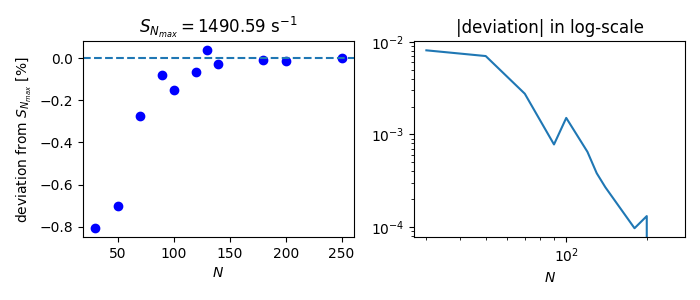

In [39]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(7,3))

# relative deviation from the best estimate of S (i.e. for the highest N):
devi = (S - S[-1]) / S[-1]

ax.plot(N_list, devi * 100, 'bo')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.axhline(0, ls='--')
ax.set_xlabel('$N$')
ax.set_title('$S_{N_{max}} = $' +'${:.2f}$ '.format(S[-1]) + 's$^{-1}$')
ax.set_ylabel('deviation from $S_{N_{max}}$ [%]')

ax2.plot(N_list, np.abs(devi))
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('|deviation| in log-scale')
ax2.set_xlabel('$N$')
plt.tight_layout()